In [12]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
# Load preprocessed data
data = pd.read_csv("../data/processed/processed_data.csv")

In [3]:
# Convert 'created_at' and 'actual_delivery_time' to datetime format, handling errors
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce', utc=True)
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], errors='coerce', utc=True)


In [4]:
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197421 entries, 0 to 197420
Data columns (total 117 columns):
 #    Column                                                   Non-Null Count   Dtype              
---   ------                                                   --------------   -----              
 0    created_at                                               197421 non-null  datetime64[ns, UTC]
 1    actual_delivery_time                                     197421 non-null  datetime64[ns, UTC]
 2    store_id                                                 197421 non-null  int64              
 3    total_items                                              197421 non-null  float64            
 4    subtotal                                                 197421 non-null  float64            
 5    num_distinct_items                                       197421 non-null  float64            
 6    min_item_price                                           197421 non-null  float64 

In [5]:
# Ensure only numeric columns are used as features
X = data.select_dtypes(include=[np.number]).drop(columns=['total_delivery_duration'])
y = data['total_delivery_duration']

# Handle infinite values, if any, in the feature set
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Recheck for any remaining NaN values and fill them as a precaution
X.fillna(X.median(), inplace=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Random Forest model
rf = RandomForestRegressor(random_state=42)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_search_rf = GridSearchCV(
    rf, param_grid_rf, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)

grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

/Users/diegovelez/Documents/Documents - Ifrit/03 RESOURCES/Courses/Henry/Delivery Duration Prediction - DoorDash/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [7]:
# Evaluate the Random Forest model
y_pred_rf = best_rf.predict(X_test)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f'Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}')

Random Forest MAE: 613.8645372865406, RMSE: 788.8531403290302


In [8]:
# XGBoost model
xgb = XGBRegressor(random_state=42, tree_method='hist')
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1]
}
grid_search_xgb = GridSearchCV(
    xgb, param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
)
grid_search_xgb.fit(X_train, y_train)
best_xgb = grid_search_xgb.best_estimator_

/Users/diegovelez/Documents/Documents - Ifrit/03 RESOURCES/Courses/Henry/Delivery Duration Prediction - DoorDash/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [9]:
# Evaluate the XGBoost model
y_pred_xgb = best_xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'XGBoost MAE: {xgb_mae}, RMSE: {xgb_rmse}')


XGBoost MAE: 591.9250061522077, RMSE: 764.9809958048869


In [10]:
# Save the best models for future use
import joblib

joblib.dump(best_rf, "../models/best_random_forest_model.pkl")
joblib.dump(best_xgb, "../models//best_xgboost_model.pkl")

['../models//best_xgboost_model.pkl']

As we found XGBoos as the best model for now, we will improve it to reduce the margin error, around 10 minutes, which is high considering the average total_delivery_duration.

In [11]:
average_duration = data['total_delivery_duration'].mean()
median_duration = data['total_delivery_duration'].median()
print(f"Average Delivery Duration: {average_duration} seconds ({average_duration / 60:.2f} minutes)")
print(f"Median Delivery Duration: {median_duration} seconds ({median_duration / 60:.2f} minutes)")

Average Delivery Duration: 2822.7809858120463 seconds (47.05 minutes)
Median Delivery Duration: 2660.0 seconds (44.33 minutes)


Feature Engineering:
- Added time-based features like hour_of_day, day_of_week, and is_weekend to capture delivery patterns based on timing.
- Introduced peak-hour flags (is_lunch_rush, is_dinner_rush) to identify common busy periods for deliveries.
- Created interaction features (busy_dashers_per_order and workload_ratio) to capture the effect of workforce load relative to demand.

In [14]:
# Extract additional time-based features
data['hour_of_day'] = data['created_at'].dt.hour
data['day_of_week'] = data['created_at'].dt.dayofweek
data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)

In [15]:
# Generate peak-hour flags
data['is_lunch_rush'] = data['hour_of_day'].isin([11, 12, 13]).astype(int)
data['is_dinner_rush'] = data['hour_of_day'].isin([18, 19, 20]).astype(int)

# Interaction terms
data['busy_dashers_per_order'] = data['total_busy_dashers'] / (data['total_outstanding_orders'] + 1)
data['workload_ratio'] = data['total_outstanding_orders'] / (data['total_onshift_dashers'] + 1)

In [23]:
# Drop unnecessary columns
data = data.drop(columns=['created_at', 'actual_delivery_time'])

Handling Categorical and Boolean Columns:
- Boolean columns (such as the outlier flags) are converted to integer types for compatibility with XGBoost.

In [21]:
# Handling Categorical and Boolean Columns
# Convert boolean columns to integers for model compatibility
bool_cols = data.select_dtypes(include='bool').columns
data[bool_cols] = data[bool_cols].astype(int)


Scaling:
- Selected numeric columns are scaled with StandardScaler to normalize features. This is essential for models like XGBoost, where feature scaling can enhance performance.

In [25]:
# Handle outliers based on existing boolean outlier columns
numeric_features = ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
                    'busy_dashers_per_order', 'workload_ratio', 'hour_of_day', 'store_id_freq', 'market_id_freq']

# For each feature, replace values marked as outliers with the median
for feature in numeric_features:
    outlier_column = f"{feature}_is_outlier"
    if outlier_column in data.columns:
        median_value = data[feature].median()
        data.loc[data[outlier_column] == 1, feature] = median_value

In [28]:
# Specific handling for columns with inf/-inf values
# Replace inf and -inf with NaN
data[['min_item_price', 'busy_dashers_per_order', 'workload_ratio']] = data[['min_item_price', 'busy_dashers_per_order', 'workload_ratio']].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with the median for each feature
for feature in ['min_item_price', 'busy_dashers_per_order', 'workload_ratio']:
    data[feature] = data[feature].fillna(data[feature].median())


In [29]:
# Scale numerical features
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

Hyperparameter Tuning:
- Extensive hyperparameter tuning is conducted using GridSearchCV to find the best configuration. This includes parameters like max_depth, n_estimators, learning_rate, subsample, colsample_bytree, reg_alpha, and reg_lambda.

In [30]:
# Define target and features
X = data.drop(columns=['total_delivery_duration'])
y = data['total_delivery_duration']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2],
}

# Initialize XGBoost model with tree method for efficiency
xgb = XGBRegressor(random_state=42, tree_method='hist')

In [31]:
# Grid search with 5-fold cross-validation
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
grid_search_xgb.fit(X_train, y_train)

# Best estimator
best_xgb = grid_search_xgb.best_estimator_

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/Users/diegovelez/Documents/Documents - Ifrit/03 RESOURCES/Courses/Henry/Delivery Duration Prediction - DoorDash/env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/diegovelez/Documents/Documents - Ifrit/03 RESOURCES/Courses/Henry/Delivery Duration Prediction - DoorDash/env/lib/python3.11/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model Evaluation:
- MAE and RMSE are calculated for the optimized model to assess its performance.
- A bar plot of feature importances is generated to understand which features contribute most to the model’s predictive power.

In [32]:
# Evaluate the Optimized XGBoost Model
y_pred_xgb = best_xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f'Optimized XGBoost MAE: {xgb_mae}, RMSE: {xgb_rmse}')

Optimized XGBoost MAE: 525.2484801480932, RMSE: 679.8895848362806


Model Saving:
- The best model is saved as a .pkl file for future use or deployment.

In [33]:
# Save the best model
joblib.dump(best_xgb, "../models/best_xgboost_optimized_model.pkl")

['../models/best_xgboost_optimized_model.pkl']

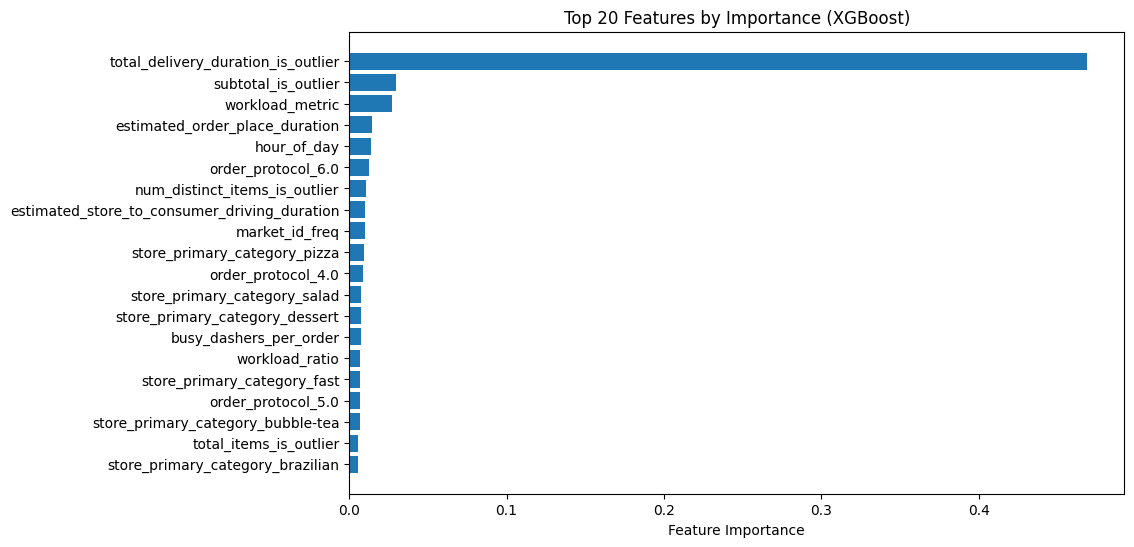

In [35]:
# Get feature importances and corresponding feature names
feature_importances = best_xgb.feature_importances_
features = X.columns

# Create a DataFrame with feature names and their importance scores
importance_df = pd.DataFrame({'feature': features, 'importance': feature_importances})

# Sort the DataFrame by importance in descending order and select the top 20
top_features = importance_df.sort_values(by='importance', ascending=False).head(20)

# Plot the top 20 features
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Features by Importance (XGBoost)')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

Top Features in the Model

- total_delivery_duration_is_outlier: This feature has the highest importance by a significant margin. It suggests that identifying whether a delivery duration is an outlier has a strong predictive power in estimating the overall delivery time. Outliers may represent unusual conditions, such as extreme traffic or other rare events that significantly affect delivery duration.

- subtotal_is_outlier: This feature is the second most important. It implies that unusually high or low order values (subtotals) impact the delivery duration. Higher subtotals might correlate with larger or more complex orders, affecting preparation and delivery times.

- workload_metric: This feature, representing the ratio of outstanding orders to available dashers, is highly influential. A high workload could delay delivery times, as dashers may take longer to reach the next customer.

- estimated_order_place_duration and estimated_store_to_consumer_driving_duration: These features are directly related to the estimated times for order placement and driving, showing that these internal estimates are valuable for prediction.

- hour_of_day: This feature is relevant as it captures the time of day, affecting factors like traffic and restaurant operating efficiency.

- Order protocols and store primary categories (such as order_protocol_6.0, store_primary_category_pizza): These features suggest that certain types of orders or cuisines might influence delivery time due to different preparation methods, popularity, or other operational reasons.

Model Performance

- With an MAE of 525.25 seconds (about 8.75 minutes), the model now predicts the delivery duration with a reduced average error compared to previous models. This is a substantial improvement from the initial results.
	
- The RMSE of 679.89 seconds (about 11.33 minutes) also suggests that the model handles variability in the data better than before. Although there’s still room for refinement, these results are closer to a reliable delivery estimate.

Model Conclusion

- The optimized XGBoost model is performing significantly better, with important features like total_delivery_duration_is_outlier and workload_metric providing valuable insights. While the model still has a moderate error margin, these results suggest it’s close to practical application, with further fine-tuning potentially reducing errors to an acceptable range for operational use.